## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-02 12:47:49--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  13.0MB/s    in 0.4s    

2025-03-02 12:47:50 (13.0 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:41
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()


(5365, 5364)

In [9]:
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [10]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    result = np.zeros((n_users, n_items))
    result[df['user_id'], df['item_id']] = df['rating']

    return result #shape ~ [n_users, n_items]

In [11]:
interactions = df_to_matrix(df_train)

In [12]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:

    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    result = coo_array((df['rating'].astype(float), (df['user_id'], df['item_id'])), shape=(n_users, n_items))
    return result # coo_array

In [13]:
coo_interactions = df_to_coo(df_train)

In [14]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [15]:
def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)


    # Для плотной матрицы
    if isinstance(interractions, np.ndarray):
        if n_singular_values == -1:
            U, s, Vh = np.linalg.svd(interractions, full_matrices=False)
        else:
            U, s, Vh = np.linalg.svd(interractions, full_matrices=False)
            U = U[:, :n_singular_values]
            s = s[:n_singular_values]
            Vh = Vh[:n_singular_values, :]

    # Для разреженной матрицы
    elif isinstance(interractions, coo_array):
        n_users, n_items = interractions.shape
        if n_singular_values == -1:
            k = min(n_users, n_items) - 1
        else:
            k = n_singular_values
        from scipy.sparse.linalg import svds
        U, s, Vh = svds(interractions, k=k)
        idx = np.argsort(s)[::-1]
        s = s[idx]
        U = U[:, idx]
        Vh = Vh[idx, :]

    S = np.diag(s)
    V = Vh

    return U, S, V

In [16]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [17]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [18]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    U, S, V = make_svd(interractions, n_singular_values)
    pred = U @ S @ V
    if isinstance(interractions, np.ndarray):
        mask = interractions != 0
    else:
        mask = interractions.toarray() != 0

    pred[mask] = -np.inf

    n_users = pred.shape[0]
    recommendations = np.empty((n_users, top_k), dtype=int)

    for i in range(n_users):
        user_pred = pred[i]
        top_indices = np.argpartition(user_pred, -top_k)[-top_k:]
        top_indices = top_indices[np.argsort(user_pred[top_indices])[::-1]]
        recommendations[i] = top_indices

    return recommendations #shape ~ [n_users, top_k]

In [19]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [20]:
def compute_ndcg(recommendations: np.ndarray, test_matrix: np.ndarray, top_k: int) -> float:
    # Вычисляет среднее NDCG по пользователям
    ndcg_scores = []
    for user in range(test_matrix.shape[0]):
        recs = recommendations[user]
        rels = (test_matrix[user, recs] > 0).astype(float)
        discounts = np.log2(np.arange(2, top_k + 2))
        dcg = np.sum(rels / discounts)
        ideal_rels = (test_matrix[user, :] > 0).astype(float)
        ideal_sorted = np.sort(ideal_rels)[::-1]
        ideal_sorted = ideal_sorted[:top_k]
        idcg = np.sum(ideal_sorted / np.log2(np.arange(2, len(ideal_sorted)+2)))
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcg_scores.append(ndcg)
    return np.mean(ndcg_scores)

In [22]:
import matplotlib.pyplot as plt
import time

def plot_graphs(interractions: Union[np.ndarray, coo_array], top_k: int = 100):
    # Для каждого значения n_singular_values из [1, 10, 50, 200, 1000]:
    #   - Вычисляет рекомендации с помощью SVD,
    #   - Замеряет время работы,
    #   - Вычисляет NDCG на тестовой матрице
    singular_values_list = [1, 10, 50, 200, 1000]
    ndcg_list = []
    runtime_list = []

    for n_sv in singular_values_list:
        start_time = time.time()
        recs = make_svd_recommendations(interractions, n_singular_values=n_sv, top_k=top_k)
        runtime = time.time() - start_time
        runtime_list.append(runtime)
        ndcg = compute_ndcg(recs, test_interactions, top_k)
        ndcg_list.append(ndcg)

        print(f"n_singular_values: {n_sv}, NDCG: {ndcg}, runtime: {runtime} sec")

    plt.figure(figsize=(12, 5))

    # График NDCG vs n_singular_values
    plt.subplot(1, 2, 1)
    plt.plot(singular_values_list, ndcg_list, marker='o')
    plt.xlabel('Количество сингулярных чисел')
    plt.ylabel('NDCG')
    plt.title('Зависимость NDCG от количества сингулярных чисел')
    plt.xscale('log')  # логарифмическая шкала

    # График времени работы vs n_singular_values
    plt.subplot(1, 2, 2)
    plt.plot(singular_values_list, runtime_list, marker='o')
    plt.xlabel('Количество сингулярных чисел')
    plt.ylabel('Время работы (сек)')
    plt.title('Зависимость времени работы от количества сингулярных чисел')
    plt.xscale('log')

    plt.tight_layout()
    plt.show()

n_singular_values: 1, NDCG: 0.0518819876561985, runtime: 78.26768326759338 sec
n_singular_values: 10, NDCG: 0.05887832204419309, runtime: 62.465320348739624 sec
n_singular_values: 50, NDCG: 0.05419701863681662, runtime: 61.48429822921753 sec
n_singular_values: 200, NDCG: 0.04135162350320344, runtime: 63.5824921131134 sec
n_singular_values: 1000, NDCG: 0.015786462393420738, runtime: 63.338186264038086 sec


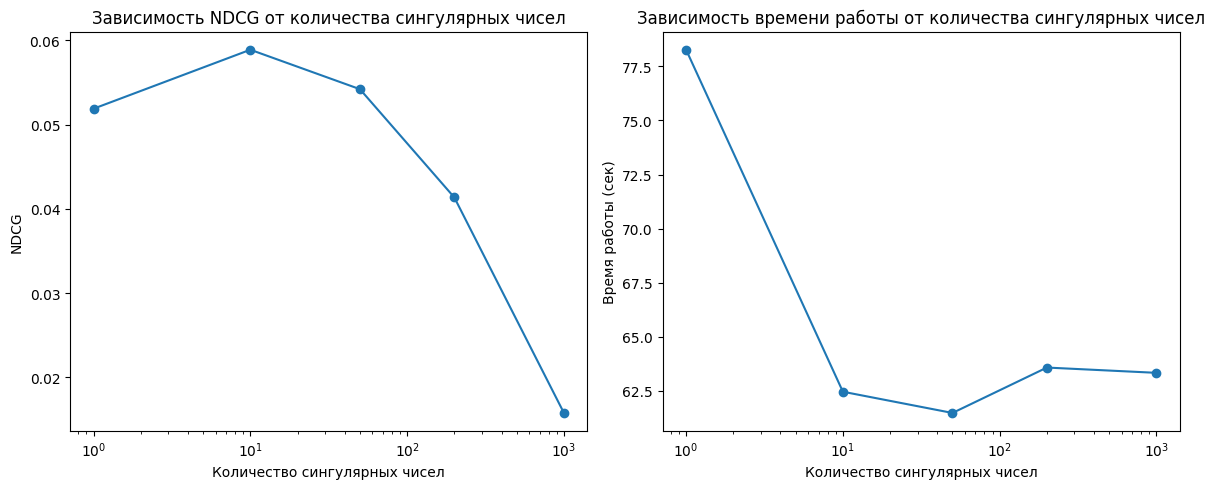

In [23]:
test_interactions = df_to_matrix(df_test)
plot_graphs(interactions)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [24]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 65.5 MB/s eta 0:00:00


In [25]:
def make_als_recommendations(
    interractions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    import scipy.sparse as sparse
    # Если матрица плотная, приводим её к разрежённому формату (формат user-item)
    if isinstance(interractions, np.ndarray):
        interactions_sparse = sparse.csr_matrix(interractions)
    elif isinstance(interractions, coo_array):
        interactions_sparse = interractions.tocsr()

    data = (alpha * interactions_sparse).astype(np.float64)

    from implicit.als import AlternatingLeastSquares
    model = AlternatingLeastSquares(factors=n_factors, regularization=regularization)
    model.fit(data)

    n_users = data.shape[0]
    recommendations = np.empty((n_users, top_k), dtype=int)

    for user in range(n_users):
        user_items = data[user]
        recs = model.recommend(user, user_items, N=top_k, filter_already_liked_items=True)
        rec_ids = [rec[0] for rec in recs]
        if len(rec_ids) < top_k:
            rec_ids.extend([-1] * (top_k - len(rec_ids)))
        recommendations[user] = rec_ids

    return recommendations #shape ~ [n_users, top_k]

In [26]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [27]:
import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares

movies_df = pd.read_csv("ml-1m/movies.dat", sep="::", names=["MovieID", "Title", "Genres"], engine="python", encoding="latin-1")
movie_dict = {int(row.MovieID): row.Title for row in movies_df.itertuples()}

# Создаем отображение закодированного id -> название фильма
encoded_to_title = {}
for encoded in range(len(item_le.classes_)):
    original_id = int(item_le.inverse_transform([encoded])[0])
    title = movie_dict.get(original_id, "Unknown")
    encoded_to_title[encoded] = title

# Приводим к разрежённому формату и типу float
interactions_sparse = sparse.csr_matrix(interactions.astype(np.float64))
alpha = 1.0
# Масштабируем данные
data = (alpha * interactions_sparse)

# Обучаем модель ALS
als_model = AlternatingLeastSquares(factors=100, regularization=0.01)
als_model.fit(data)

num_users_to_explain = 5
top_k = 10

for user in range(num_users_to_explain):
    user_items_row = data[user]
    recs = als_model.recommend(user, user_items_row, N=top_k, filter_already_liked_items=True)
    print(f"\nПользователь {user}:")
    for rec in recs:
        rec_item = int(rec[0])
        explanation = als_model.explain(user, data, rec_item)
        predicted_score, contributions = explanation[0], explanation[1]
        title = encoded_to_title.get(rec_item, "Unknown")
        print(f"Фильм: {title} (encoded id: {rec_item}), predicted score: {predicted_score:.2f}")
        print(f"Вклады факторов: {np.round(contributions, 3)}")
        print("_"*70)

  0%|          | 0/15 [00:00<?, ?it/s]


Пользователь 0:
Фильм: Close Shave, A (1995) (encoded id: 580), predicted score: 0.79
Вклады факторов: [[8.460e+02 4.000e-01]
 [5.670e+02 1.750e-01]
 [2.301e+03 3.200e-02]
 [8.910e+02 2.900e-02]
 [7.770e+02 2.700e-02]
 [2.833e+03 2.600e-02]
 [8.270e+02 2.000e-02]
 [2.971e+03 2.000e-02]
 [2.173e+03 2.000e-02]
 [2.119e+03 1.800e-02]]
______________________________________________________________________
Фильм: Toy Story (1995) (encoded id: 0), predicted score: -0.00
Вклады факторов: [[2.544e+03 7.600e-02]
 [8.460e+02 6.300e-02]
 [6.660e+02 4.000e-02]
 [2.602e+03 3.000e-02]
 [4.490e+02 2.800e-02]
 [6.810e+02 2.700e-02]
 [2.627e+03 2.200e-02]
 [2.168e+03 2.000e-02]
 [8.250e+02 1.800e-02]
 [6.820e+02 1.800e-02]]
______________________________________________________________________

Пользователь 1:
Фильм: Chinatown (1974) (encoded id: 929), predicted score: 1.04
Вклады факторов: [[1.203e+03 1.510e-01]
 [4.620e+02 1.130e-01]
 [6.840e+02 1.020e-01]
 [6.750e+02 9.800e-02]
 [2.788e+03 9.400e-0

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [29]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from datetime import timedelta

# Предполагается, что df_train и df_test уже загружены и содержат столбцы:
# 'user_id', 'item_id', 'rating', 'datetime'
# а также, что для пользователей и айтемов применён LabelEncoder (item_le, user_le)
# и что функции df_to_matrix, make_svd_recommendations, make_als_recommendations и compute_ndcg уже реализованы.

# Функция для преобразования DataFrame в матрицу интеракций (уже реализована ранее)
# def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
#     ...

# ---------------------------
# Функции преобразования обучающей выборки
# ---------------------------

def transform_all_to_1(df):
    """Бинаризация всех рейтингов"""
    df_bin = df.copy()
    df_bin['rating'] = 1
    return df_to_matrix(df_bin)

def transform_45_to_1_else_0(df):
    """Если рейтинг >= 4, то 1, иначе 0"""
    df_bin = df.copy()
    df_bin['rating'] = df_bin['rating'].apply(lambda x: 1 if x >= 4 else 0)
    return df_to_matrix(df_bin)

def transform_45_to_1_else_minus1(df):
    """Если рейтинг >= 4, то 1, иначе -1"""
    df_bin = df.copy()
    df_bin['rating'] = df_bin['rating'].apply(lambda x: 1 if x >= 4 else -1)
    return df_to_matrix(df_bin)

def transform_with_time_decay(df):
    """
    Если рейтинг >= 4, то 1, иначе -1, с временным сглаживанием
    Здесь используется экспоненциальное затухание decay = 0.9^(months_diff)
    """
    df_decay = df.copy()
    max_date = df_decay['datetime'].max()

    def compute_decay(row):
        months_diff = (max_date - row['datetime']).days / 30.0
        return 0.9 ** months_diff

    df_decay['decay'] = df_decay.apply(compute_decay, axis=1)
    df_decay['rating'] = df_decay.apply(lambda row: (1 if row['rating'] >= 4 else -1) * row['decay'], axis=1)
    return df_to_matrix(df_decay)

mat1 = transform_all_to_1(df_train)
mat2 = transform_45_to_1_else_0(df_train)
mat3 = transform_45_to_1_else_minus1(df_train)
mat4 = transform_with_time_decay(df_train)

transforms = {
    "Бинаризация всех рейтингов": mat1,
    "Рейтинги 4 и 5 -> 1, иначе 0": mat2,
    "Рейтинги 4 и 5 -> 1, иначе -1": mat3,
    "Рейтинги 4 и 5 -> 1, иначе -1 с временным сглаживанием": mat4
}

results = {}

for name, train_mat in transforms.items():
    print("Преобразование:", name)

    # Обучение ALS на преобразованной обучающей выборке
    als_recs = make_als_recommendations(train_mat, top_k=100, n_factors=100, alpha=1.0, regularization=0.01)
    als_ndcg = compute_ndcg(als_recs, test_interactions, top_k=100)

    # Обучение SVD на той же матрице
    svd_recs = make_svd_recommendations(train_mat, n_singular_values=-1, top_k=100)
    svd_ndcg = compute_ndcg(svd_recs, test_interactions, top_k=100)

    results[name] = {"ALS NDCG": als_ndcg, "SVD NDCG": svd_ndcg}

    print(f"  ALS NDCG: {als_ndcg}")
    print(f"  SVD NDCG: {svd_ndcg}")
    print("_"*60)

Преобразование: Бинаризация всех рейтингов


  0%|          | 0/15 [00:00<?, ?it/s]

  ALS NDCG: 0.05969430831038014
  SVD NDCG: 0.025979801462092597
____________________________________________________________
Преобразование: Рейтинги 4 и 5 -> 1, иначе 0


  0%|          | 0/15 [00:00<?, ?it/s]

  ALS NDCG: 0.05824096096748762
  SVD NDCG: 0.022178142444895358
____________________________________________________________
Преобразование: Рейтинги 4 и 5 -> 1, иначе -1


  0%|          | 0/15 [00:00<?, ?it/s]

  ALS NDCG: 0.05924666864454309
  SVD NDCG: 0.018760438096471706
____________________________________________________________
Преобразование: Рейтинги 4 и 5 -> 1, иначе -1 с временным сглаживанием


  0%|          | 0/15 [00:00<?, ?it/s]

  ALS NDCG: 0.05947035214458706
  SVD NDCG: 0.020833992888859208
____________________________________________________________


Для обеих моделей наилучшие показатели получены при бинаризации всех рейтингов, то есть при замене любой интеракции на 1. Для ALS NDCG равен 0.0598, а для SVD — 0.0260, что немного выше, чем у остальных вариантов

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [30]:
import numpy as np

class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef: float = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.X = None
        self.Y = None
        self.R = None

    def fit(self, interractions: np.ndarray, n_iterations: int = 10):
        self.R = interractions.copy().astype(np.float64)
        n_users, n_items = self.R.shape
        R = self.R
        P = (R > 0).astype(np.float64)
        C = 1 + self.alpha * R
        # Инициализируем X и Y случайными значениями
        self.X = np.random.rand(n_users, self.n_factors)
        self.Y = np.random.rand(n_items, self.n_factors)
        # Единичная матрица для регуляризации
        I_f = np.eye(self.n_factors)
        for it in range(n_iterations):
            YtY = self.Y.T.dot(self.Y)  # (n_factors x n_factors)
            for u in range(n_users):
                idx = np.nonzero(P[u])[0]
                if len(idx) > 0:
                    # A = Y^TY + sum_{i in I_u} (c_ui - 1) * y_i y_i^T + reg_coef * I
                    # b = sum_{i in I_u} c_ui * y_i
                    Y_u = self.Y[idx]  # shape (|I_u| x n_factors)
                    Cu_minus_I = C[u, idx] - 1.0  # длина |I_u|
                    A = YtY + (Y_u.T * Cu_minus_I).dot(Y_u) + self.reg_coef * I_f
                    b = (self.Y[idx].T * C[u, idx]).sum(axis=1)
                    self.X[u] = np.linalg.solve(A, b)
                else:
                    A = YtY + self.reg_coef * I_f
                    b = np.zeros(self.n_factors)
                    self.X[u] = np.linalg.solve(A, b)
            XtX = self.X.T.dot(self.X)
            for i in range(n_items):
                idx = np.nonzero(P[:, i])[0]
                if len(idx) > 0:
                    X_i = self.X[idx]  # |U_i| x n_factors
                    Ci_minus_I = C[idx, i] - 1.0
                    A = XtX + (X_i.T * Ci_minus_I).dot(X_i) + self.reg_coef * I_f
                    b = (self.X[idx].T * C[idx, i]).sum(axis=1)
                    self.Y[i] = np.linalg.solve(A, b)
                else:
                    A = XtX + self.reg_coef * I_f
                    b = np.zeros(self.n_factors)
                    self.Y[i] = np.linalg.solve(A, b)

            print(f"Итерация {it+1}/{n_iterations}")
        return self

    def predict(self, top_k: int = 100):
        """
        Возвращает для каждого пользователя индексы top_k айтемов, которые не входят в его исходные интеракции
        """
        scores = self.X.dot(self.Y.T)
        mask = (self.R > 0)
        scores[mask] = -np.inf

        n_users = scores.shape[0]
        predictions = np.empty((n_users, top_k), dtype=int)
        for u in range(n_users):
            top_items = np.argpartition(scores[u], -top_k)[-top_k:]
            top_items = top_items[np.argsort(scores[u, top_items])[::-1]]
            predictions[u] = top_items
        return predictions

In [31]:
ials_model = iALS(n_factors=100, alpha=1.0, reg_coef=0.01)
ials_model.fit(interactions, n_iterations=10)
predictions = ials_model.predict(top_k=100)
print("predictions shape", predictions.shape)

Итерация 1/10
Итерация 2/10
Итерация 3/10
Итерация 4/10
Итерация 5/10
Итерация 6/10
Итерация 7/10
Итерация 8/10
Итерация 9/10
Итерация 10/10
predictions shape (5365, 100)


In [32]:
ndcg_value = compute_ndcg(predictions, test_interactions, top_k=100)
ndcg_value

0.048695629041436594